# Quant Trading Strategies HW 5 - Madison Rusch (12365298)
## FX Carry Strategy

## Data

In [481]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13
import quandl
import pandas as pd
import numpy as np
import functools
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
import seaborn as sns
import datetime
import statsmodels.api as sm

# Fetch Data
@functools.lru_cache(maxsize=1600)
def fetch_quandl(my_data_items, trim_start=None, trim_end=None, returns="pandas", columns = []):
    qopts = {}
    if len(columns) > 0:
        qopts['columns'] = list(columns)
    qdata = quandl.get(list(my_data_items), returns=returns, 
                      trim_start=trim_start,
                      trim_end=trim_end,
                      qopts = qopts,
                      api_key='bXgDCzJUfS5ZxasswLcN')
    return qdata

### UK OIS and Spot

In [482]:

OIS_TABLE = 'YC/GBR_ISSC'

ois_data = fetch_quandl((OIS_TABLE,))
ois_data = ois_data[['YC/GBR_ISSC - 0.08Y', 'YC/GBR_ISSC - 5.0Y']]
ois_data = ois_data.rename(columns={'YC/GBR_ISSC - 0.08Y': 'OIS GBP', 'YC/GBR_ISSC - 5.0Y': 'GBP 5-Year'})

OIS_TABLE_2 = 'YC/GBR_ISSS'

ois_data_2 = fetch_quandl((OIS_TABLE_2,))
ois_data_2 = ois_data_2[['YC/GBR_ISSS - 0.08Y', 'YC/GBR_ISSS - 5.0Y']]
ois_data_2 = ois_data_2.rename(columns={'YC/GBR_ISSS - 0.08Y': 'OIS GBP', 'YC/GBR_ISSS - 5.0Y': 'GBP 5-Year'})

ois_data = pd.concat([ois_data, ois_data_2])
# ois_data = ois_data.resample('W-WED').last()
idx = ois_data.drop_duplicates().resample('W-WED').asfreq().index 
ois_data = ois_data.drop_duplicates().reindex(ois_data.index.union(idx)).ffill().resample('W-WED').first().dropna()
display(ois_data)

,OIS GBP,GBP 5-Year
Date,,
2009-01-07,1.279724,2.449408
2009-01-14,1.090821,2.367053
2009-01-21,1.125153,2.382920
2009-01-28,1.003170,2.378335
2009-02-04,0.914141,2.384492
...,...,...
2022-11-23,3.007526,3.770436
2022-11-30,3.079973,3.742757
2022-12-07,3.199725,3.686635


In [483]:
SPOT_TABLE_CURRENCIES = ('CUR/GBP', 'CUR/VND', 'CUR/THB', 'CUR/PKR', 'CUR/PHP')

spot_rates = fetch_quandl(SPOT_TABLE_CURRENCIES)
spot_rates = spot_rates.rename(columns = {'CUR/GBP - RATE': 'GBP',
                                          'CUR/VND - RATE': 'VND',
                                          'CUR/THB - RATE': 'THB',
                                          'CUR/PKR - RATE': 'PKR',
                                          'CUR/PHP - RATE': 'PHP'})
display(spot_rates)

,GBP,VND,THB,PKR,PHP
DATE,,,,,
2000-01-01,0.618877,NaN,37.650815,NaN,NaN
2000-01-02,0.618877,NaN,37.650815,NaN,NaN
2000-01-03,0.614647,NaN,37.078056,NaN,40.102983
2000-01-04,0.610927,NaN,37.094539,NaN,39.830575
2000-01-05,0.609433,NaN,37.151837,NaN,40.148695
...,...,...,...,...,...
2023-02-06,0.828652,23487.965335,33.508500,250.502000,54.401996
2023-02-07,0.829958,23537.500000,33.638000,275.895866,55.023497
2023-02-08,0.829610,23592.500000,33.529852,274.704700,54.930496


### Yield curves for other currencies

In [484]:
YC_TABLE = ('YC/VNM', 'YC/THA', 'YC/PAK', 'YC/PHL')

yc_data = fetch_quandl(YC_TABLE)
yc_data = yc_data[['YC/VNM - 1-Year', 
                   'YC/VNM - 3-Year', 
                   'YC/VNM - 5-Year', 
                   'YC/THA - 1-Year', 
                   'YC/THA - 3-Year', 
                   'YC/THA - 5-Year',
                   'YC/PAK - 3-Year', 
                   'YC/PAK - 5-Year',
                   'YC/PHL - 1-Year', 
                   'YC/PHL - 3-Year', 
                   'YC/PHL - 5-Year']]
yc_data = yc_data.rename(columns={'YC/VNM - 1-Year' : 'VNM 1-Year',
                                  'YC/VNM - 3-Year' : 'VNM 3-Year',
                                  'YC/VNM - 5-Year' : 'VNM 5-Year',
                                  'YC/THA - 1-Year' : 'THA 1-Year',
                                  'YC/THA - 3-Year' : 'THA 3-Year',
                                  'YC/THA - 5-Year' : 'THA 5-Year',
                                  'YC/PAK - 3-Year' : 'PAK 3-Year',
                                  'YC/PAK - 5-Year' : 'PAK 5-Year',
                                  'YC/PHL - 1-Year' : 'PHL 1-Year',
                                  'YC/PHL - 3-Year' : 'PHL 3-Year',
                                  'YC/PHL - 5-Year' : 'PHL 5-Year',})
yc_data['GBP 5-Year'] = ois_data['GBP 5-Year']
display(yc_data[yc_data.index > '2020-05-10'])

,VNM 1-Year,VNM 3-Year,VNM 5-Year,THA 1-Year,THA 3-Year,THA 5-Year,PAK 3-Year,PAK 5-Year,PHL 1-Year,PHL 3-Year,PHL 5-Year,GBP 5-Year
Date,,,,,,,,,,,,
2020-05-11,1.633,1.920,2.116,0.587,0.680,0.805,NaN,NaN,2.9340,2.9640,3.1310,NaN
2020-05-12,1.575,1.780,2.107,0.582,0.674,0.804,NaN,NaN,2.8510,2.9880,3.1300,NaN
2020-05-13,1.583,1.758,2.100,0.574,0.654,0.767,NaN,NaN,2.8100,2.9370,3.0650,0.110996
2020-05-14,1.575,1.792,2.106,0.568,0.655,0.762,NaN,NaN,2.7970,2.9110,3.0220,NaN
2020-05-15,1.583,1.846,2.129,0.567,0.647,0.743,NaN,NaN,2.7600,2.9170,3.0150,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-03,3.761,3.782,3.832,1.592,1.790,2.060,NaN,NaN,5.3050,5.5749,5.8230,NaN
2023-02-06,3.777,3.782,3.823,1.606,1.825,2.067,NaN,NaN,5.3081,5.6021,5.8394,NaN
2023-02-07,3.782,3.786,3.836,1.647,1.838,2.073,NaN,NaN,5.3134,5.6312,5.8887,NaN


## The First Trade: GBP vs VNM

For this first trade, we will study Vietnamese currency

In [485]:
data_for_trade = yc_data[['VNM 1-Year', 'VNM 3-Year', 'VNM 5-Year', 'GBP 5-Year']]
# Resample to Weekly data (on Wednesday)
idx = data_for_trade.resample('W-WED').asfreq().index 
data_for_trade = data_for_trade.reindex(data_for_trade.index.union(idx)).ffill().resample('W-WED').first().dropna()
# display(data_for_trade[data_for_trade.index > '2020-05-10'])

Now we can cycle through each week, borrowing at the lowest rate and lending at the highest. Based on the swap data above, we will likely be borrowing at the THA 1-Year rate and lending at the VNM 5-Year.

In [486]:
CURRENCY_TO_COUNTRY_MAPPING = {
    'VNM': 'VND',
    'THA': 'THB',
    'PAK': 'PKR',
    'PHL': 'PHP',
    'GBP': 'GBP'
}


def compute_zcb_curve(spot_rates_curve, rates):
    zcb_rates = spot_rates_curve.copy()
    result = pd.DataFrame(index = rates)
    index = 0
    for tenor in rates:
        times = np.arange(tenor-0.25, 0, step=-0.25)[::-1]
        coupon_quarter_yr = 0.25*spot_rates_curve.iloc[index]
        z = np.interp(times, rates, zcb_rates.values) # Linear interpolation
        preceding_coupons_val = (coupon_quarter_yr*np.exp(-z*times)).sum()
        result.loc[tenor, 'Rate'] = -np.log((1-preceding_coupons_val)/(1+coupon_quarter_yr))/tenor
        index += 1
    return result

def bond_price(zcb, coupon_rate, tenor):
    times = np.arange(tenor, 0, step=-0.25)[::-1]
    if times.shape[0]==0:
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, zcb['Rate'].values) # Linear interpolation
        p = np.exp(-tenor*r[-1]) + 0.25 * coupon_rate * np.exp(-r*times).sum()
    return p


def carry_trade(lending_currency, rate_tenors = [1,3,5]):
    
    LENDING_CURRENCY = lending_currency
    BORROWING_CURRENCY = 'GBP'
    pnl_df = pd.DataFrame(index=data_for_trade.index)
    for date in data_for_trade.index.values[0:-1]:
        next_week = date + pd.DateOffset(weeks = 1)
        # First get conversion rates to USD
        rates = data_for_trade.loc[date]
        # Only trade if we have OIS
        if date in list(ois_data.index.values):
            # Only trade if the 5Y swaps are farther apart than 50 bp
            if rates[f'{LENDING_CURRENCY} 5-Year'] - rates[f'{BORROWING_CURRENCY} 5-Year'] > 0.5 and (next_week in list(data_for_trade.index.values)):
                # Start with the borrowing currency
                conversion = spot_rates.loc[date, CURRENCY_TO_COUNTRY_MAPPING[BORROWING_CURRENCY]]
                coupon_rate = rates[f'{LENDING_CURRENCY} 5-Year']
                
                # Initial Position = 10 Million USD * Rate
                foreign_initial_position = 10_000_000 * conversion
                # We borrow 0.8 of it
                foreign_borrowed = 0.8 * foreign_initial_position
                pnl_df.loc[date, 'Borrowed'] = 8_000_000
                
                # Close out the position
                closing_conversion = spot_rates.loc[next_week, CURRENCY_TO_COUNTRY_MAPPING[BORROWING_CURRENCY]]
                foreign_owed = foreign_borrowed / closing_conversion
                pnl_df.loc[date, 'Owed'] = foreign_owed
                
                # At the end of the week, pay back the interest on the borrowed money
                funding_rate = (ois_data.loc[date, 'OIS GBP'] + 0.5) / 52 / 100
                interest_owed = funding_rate * foreign_borrowed / closing_conversion
                pnl_df.loc[date, 'Interest'] = interest_owed

                pnl_usd = (8_000_000 - foreign_owed - interest_owed)
                pnl_df.loc[date, 'Borrowed PNL (USD)'] = pnl_usd
                
                # Next do lending currency
                if 1 not in rate_tenors:
                    original_spot_curve_rates = rates[[f'{LENDING_CURRENCY} 3-Year', f'{LENDING_CURRENCY} 5-Year']]/100
                else:
                    original_spot_curve_rates = rates[[f'{LENDING_CURRENCY} 1-Year', f'{LENDING_CURRENCY} 3-Year', f'{LENDING_CURRENCY} 5-Year']]/100
                zcb_curve = compute_zcb_curve(original_spot_curve_rates, rate_tenors)
                original_bond_price =  bond_price(zcb_curve, coupon_rate=coupon_rate/100, tenor=5)

                # Figure out how much you spent on the bonds
                conversion = spot_rates.loc[date, CURRENCY_TO_COUNTRY_MAPPING[LENDING_CURRENCY]]
                bonds_bought = 10_000_000 * conversion / original_bond_price
                pnl_df.loc[date, 'Bonds Bought'] = 10_000_000
                
                # Figure out how much you can sell them back for a week later
                next_week_rates = data_for_trade.loc[next_week]
                
                if 1 not in rate_tenors:
                    spot_curve_rates = next_week_rates[[f'{LENDING_CURRENCY} 3-Year', f'{LENDING_CURRENCY} 5-Year']]/100
                else:
                    spot_curve_rates = next_week_rates[[f'{LENDING_CURRENCY} 1-Year', f'{LENDING_CURRENCY} 3-Year', f'{LENDING_CURRENCY} 5-Year']]/100
                zcb_curve = compute_zcb_curve(spot_curve_rates, rate_tenors)
                new_bond_price =  bond_price(zcb_curve, coupon_rate=coupon_rate/100, tenor=(5*365-7)/365)
                sell_back = new_bond_price * bonds_bought
                        
                closing_conversion = spot_rates.loc[next_week, CURRENCY_TO_COUNTRY_MAPPING[LENDING_CURRENCY]]
                sell_back_usd = sell_back / closing_conversion        
                pnl_df.loc[date, 'Bonds Sold'] = sell_back_usd

                pnl_df.loc[date, 'Loaned PNL (USD)'] = sell_back_usd - 10_000_000


    pnl_df['Net PNL'] = pnl_df['Borrowed PNL (USD)'] + pnl_df['Loaned PNL (USD)']
    pnl_df['Cumulative Sum'] = pnl_df['Net PNL'].cumsum()
    pnl_df = pnl_df.dropna()
    return pnl_df

pnldf = carry_trade('VNM')
display(pnldf)

all_pnls = pd.DataFrame(index = pnldf.index)
all_pnls['VNM PNL'] = pnldf['Net PNL']

,Borrowed,Owed,Interest,Borrowed PNL (USD),Bonds Bought,Bonds Sold,Loaned PNL (USD),Net PNL,Cumulative Sum
Date,,,,,,,,,
2014-12-03,8000000.0,8.017739e+06,1430.950794,-19169.756002,10000000.0,9.990172e+06,-9827.876323,-28997.632326,-2.899763e+04
2014-12-10,8000000.0,7.927779e+06,1414.275087,70806.510970,10000000.0,9.995061e+06,-4938.510618,65868.000352,3.687037e+04
2014-12-17,8000000.0,7.990630e+06,1421.603156,7948.511715,10000000.0,9.798625e+06,-201375.338357,-193426.826641,-1.565565e+05
2014-12-24,8000000.0,8.012825e+06,1429.328984,-14254.435782,10000000.0,1.010657e+07,106569.720396,92315.284615,-6.424117e+04
2014-12-31,8000000.0,7.758822e+06,1386.878384,239791.209852,10000000.0,1.002862e+07,28619.663267,268410.873118,2.041697e+05
...,...,...,...,...,...,...,...,...,...
2022-11-23,8000000.0,8.062879e+06,5438.607086,-68317.388612,10000000.0,1.008486e+07,84861.568531,16544.179919,6.230572e+06
2022-11-30,8000000.0,8.099906e+06,5576.432340,-105482.673205,10000000.0,1.033629e+07,336293.400720,230810.727515,6.461382e+06
2022-12-07,8000000.0,8.148882e+06,5797.813000,-154680.304754,10000000.0,1.016664e+07,166640.670727,11960.365974,6.473343e+06


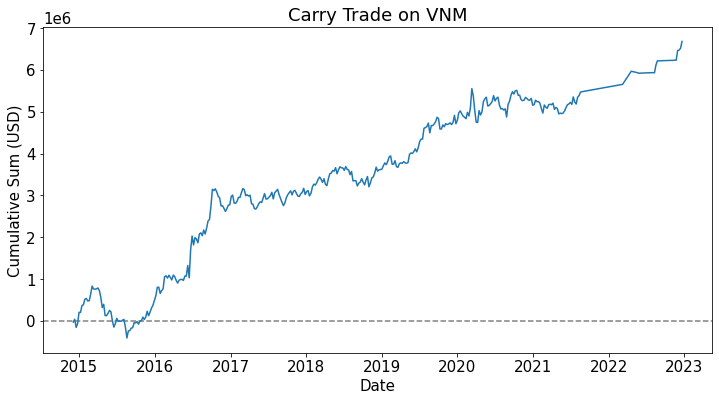

In [487]:
plt.title("Carry Trade on VNM")
plt.xlabel('Date')
plt.ylabel('Cumulative Sum (USD)')
plt.axhline(y=0, linestyle='--', color='grey')
plt.plot(pnldf['Cumulative Sum'])

We can see from the chart above that this trade seemed to go well for us. Over the course of 8 years we made almost 7 million US Dollars on a 2 million dollar capital investment, and that from besides a small dip in 2015, we were always profitable enough to continue the trade. There don't appear to be any extreme losses (that would wipe us out), even in periods of economic turmoil like Covid.

## The Second Trade: GBP vs THA

For this next trade, we will study Thai currency

In [488]:
data_for_trade = yc_data[['THA 1-Year', 'THA 3-Year', 'THA 5-Year', 'GBP 5-Year']]
# Resample to Weekly data (on Wednesday)
idx = data_for_trade.resample('W-WED').asfreq().index 
data_for_trade = data_for_trade.reindex(data_for_trade.index.union(idx)).ffill().resample('W-WED').first().dropna()
# display(data_for_trade)

In [489]:
pnldf = carry_trade('THA')
display(pnldf)
all_pnls['THA PNL'] = pnldf['Net PNL']

,Borrowed,Owed,Interest,Borrowed PNL (USD),Bonds Bought,Bonds Sold,Loaned PNL (USD),Net PNL,Cumulative Sum
Date,,,,,,,,,
2014-12-03,8000000.0,8.017739e+06,1430.950794,-19169.756002,10000000.0,1.000474e+07,4738.595916,-14431.160087,-1.443116e+04
2014-12-10,8000000.0,7.927779e+06,1414.275087,70806.510970,10000000.0,9.933223e+06,-66776.856319,4029.654651,-1.040151e+04
2014-12-17,8000000.0,7.990630e+06,1421.603156,7948.511715,10000000.0,1.000758e+07,7580.943665,15529.455381,5.127950e+03
2014-12-24,8000000.0,8.012825e+06,1429.328984,-14254.435782,10000000.0,1.000100e+07,996.264708,-13258.171074,-8.130221e+03
2014-12-31,8000000.0,7.758822e+06,1386.878384,239791.209852,10000000.0,1.001357e+07,13569.830255,253361.040106,2.452308e+05
...,...,...,...,...,...,...,...,...,...
2021-06-09,8000000.0,7.963665e+06,839.801816,35495.044531,10000000.0,1.004444e+07,44438.688170,79933.732701,2.616912e+06
2021-09-15,8000000.0,7.909120e+06,837.193759,90042.358888,10000000.0,9.822671e+06,-177329.014315,-87286.655427,2.529625e+06
2021-10-27,8000000.0,7.916080e+06,962.286706,82957.266762,10000000.0,1.001799e+07,17985.840832,100943.107595,2.630568e+06


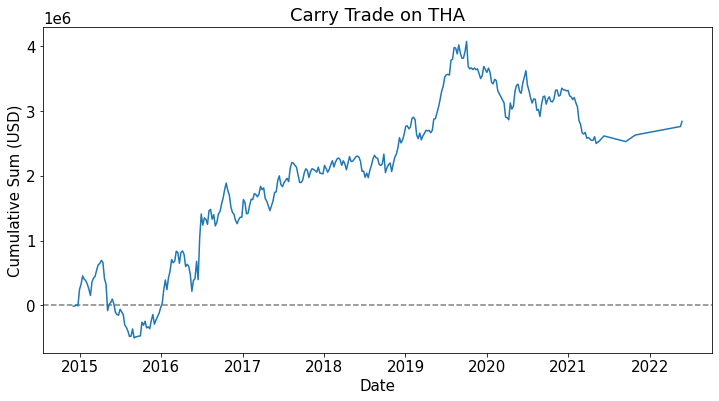

In [490]:
plt.title("Carry Trade on THA")
plt.xlabel('Date')
plt.ylabel('Cumulative Sum (USD)')
plt.axhline(y=0, linestyle='--', color='grey')
plt.plot(pnldf['Cumulative Sum'])

This trade appears less profitable than the Vietnamese one. While we still made money, there is a larger amount of time when we saw an overall loss on the strategy. The half a year time frame in 2015, while appearing relatively small on the overall scale, would be enough for a portfolio manager to consider ending the trade before any profits were realized. There were also times where the trade appeared to do very poorly in 2019, another time at which a trader might consider cutting losses and stopping the trade.

## The Third Trade: GBP vs PAK

For the third trade, we will study Pakistani currency

In [491]:
data_for_trade = yc_data[['PAK 3-Year', 'PAK 5-Year', 'GBP 5-Year']]
# Resample to Weekly data (on Wednesday)
idx = data_for_trade.resample('W-WED').asfreq().index 
data_for_trade = data_for_trade.reindex(data_for_trade.index.union(idx)).ffill().resample('W-WED').first().dropna()
# display(data_for_trade)

In [492]:
pnldf = carry_trade('PAK', rate_tenors=[3,5])
display(pnldf)
all_pnls['PAK PNL'] = pnldf['Net PNL']

,Borrowed,Owed,Interest,Borrowed PNL (USD),Bonds Bought,Bonds Sold,Loaned PNL (USD),Net PNL,Cumulative Sum
Date,,,,,,,,,
2014-08-13,8000000.0,7.909237e+06,1412.960216,89350.190769,10000000.0,9.872052e+06,-127947.787292,-38597.596523,-3.859760e+04
2014-08-20,8000000.0,7.964041e+06,1414.381311,34545.046872,10000000.0,9.885382e+06,-114618.320171,-80073.273299,-1.186709e+05
2014-08-27,8000000.0,7.964936e+06,1413.274149,33650.634139,10000000.0,9.984141e+06,-15859.398606,17791.235533,-1.008796e+05
2014-09-03,8000000.0,7.822766e+06,1389.800423,175843.942279,10000000.0,1.006573e+07,65726.715919,241570.658199,1.406910e+05
2014-09-10,8000000.0,8.074519e+06,1438.310545,-75957.326387,10000000.0,9.910747e+06,-89253.307884,-165210.634271,-2.451961e+04
...,...,...,...,...,...,...,...,...,...
2022-11-23,8000000.0,8.062879e+06,5438.607086,-68317.388612,10000000.0,9.934701e+06,-65298.504674,-133615.893286,2.932782e+06
2022-11-30,8000000.0,8.099906e+06,5576.432340,-105482.673205,10000000.0,1.001290e+07,12903.693730,-92578.979475,2.840203e+06
2022-12-07,8000000.0,8.148882e+06,5797.813000,-154680.304754,10000000.0,1.004458e+07,44583.772758,-110096.531995,2.730106e+06


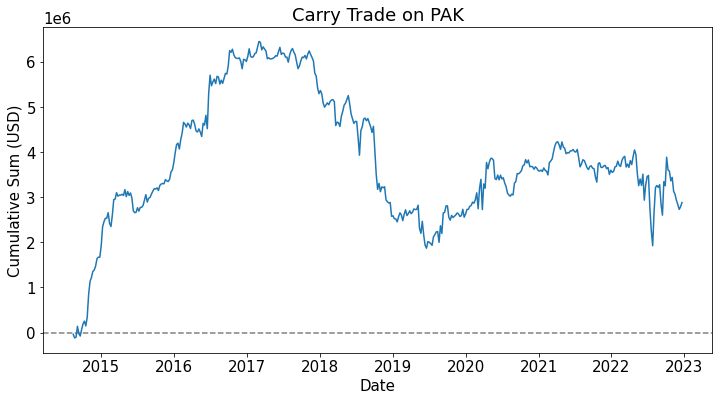

In [493]:
plt.title("Carry Trade on PAK")
plt.xlabel('Date')
plt.ylabel('Cumulative Sum (USD)')
plt.axhline(y=0, linestyle='--', color='grey')
plt.plot(pnldf['Cumulative Sum'])

The trade on Pakistani currency has both good and bad points. In its favor is the fact that we don't have the below zero profits that we saw in both Vietnamese and Thai currency in 2015. However, starting in 2017, the carry trade on Pakistani currency saw an enormous downturn, and close to two years of negative returns. It was so bad in fact that even the next four years of executing a carry trade could not recover the losses. This trade peaked in profit at $6 million, but it did so at the beginning of 2017 and we didn't see nearly as much profit over the next six years. This graph would imply that there are other factors that influenced the Pakistani returns (given that we held the borrowing currency constant between this and the other two trades we've already looked at). It is important to note that it is not enough to 'trust the math' on this carry trade, and that we need to keep macro economic factors in mind given our susceptability to the foreign exchange rate.

## The Fourth Trade: GBP vs PHL

For the final trade, we will study Filipino currency

In [494]:
data_for_trade = yc_data[['PHL 1-Year', 'PHL 3-Year', 'PHL 5-Year', 'GBP 5-Year']]
# Resample to Weekly data (on Wednesday)
idx = data_for_trade.resample('W-WED').asfreq().index 
data_for_trade = data_for_trade.reindex(data_for_trade.index.union(idx)).ffill().resample('W-WED').first().dropna()
# display(data_for_trade)

In [495]:
pnldf = carry_trade('PHL')
display(pnldf)
all_pnls['PHL PNL'] = pnldf['Net PNL']

,Borrowed,Owed,Interest,Borrowed PNL (USD),Bonds Bought,Bonds Sold,Loaned PNL (USD),Net PNL,Cumulative Sum
Date,,,,,,,,,
2014-12-03,8000000.0,8.017739e+06,1430.950794,-19169.756002,10000000.0,1.002445e+07,24447.939576,5278.183574,5.278184e+03
2014-12-10,8000000.0,7.927779e+06,1414.275087,70806.510970,10000000.0,9.977096e+06,-22904.342039,47902.168931,5.318035e+04
2014-12-17,8000000.0,7.990630e+06,1421.603156,7948.511715,10000000.0,9.965594e+06,-34406.088728,-26457.577013,2.672278e+04
2014-12-24,8000000.0,8.012825e+06,1429.328984,-14254.435782,10000000.0,9.984269e+06,-15730.620382,-29985.056164,-3.262281e+03
2014-12-31,8000000.0,7.758822e+06,1386.878384,239791.209852,10000000.0,9.968468e+06,-31532.064036,208259.145816,2.049969e+05
...,...,...,...,...,...,...,...,...,...
2022-11-23,8000000.0,8.062879e+06,5438.607086,-68317.388612,10000000.0,1.021379e+07,213785.119142,145467.730529,1.604945e+06
2022-11-30,8000000.0,8.099906e+06,5576.432340,-105482.673205,10000000.0,1.021193e+07,211933.923366,106451.250161,1.711396e+06
2022-12-07,8000000.0,8.148882e+06,5797.813000,-154680.304754,10000000.0,1.003484e+07,34837.476638,-119842.828115,1.591553e+06


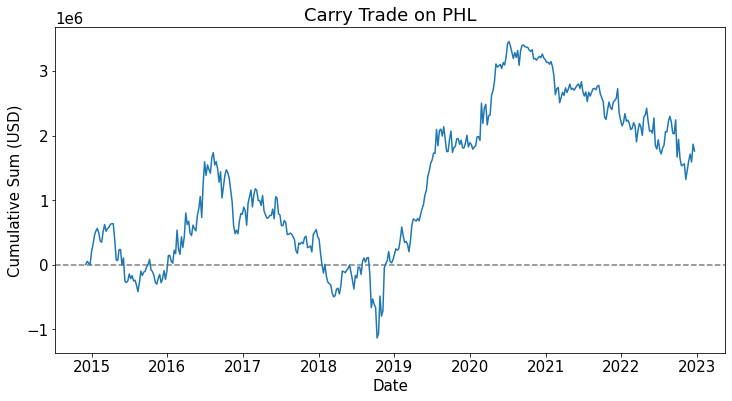

In [496]:
plt.title("Carry Trade on PHL")
plt.xlabel('Date')
plt.ylabel('Cumulative Sum (USD)')
plt.axhline(y=0, linestyle='--', color='grey')
plt.plot(pnldf['Cumulative Sum'])

For this final trade, we once again see profit, but like the others mostly executed in a short period of time, while the rest of the time periods show a lot of volatility or overall downturn in the profits. Filipino currency saw a very unstable 2015-2018, and was only a really good strategy from late 2018 to mid-2020. The volatility of this strategy is not unexpected, but once again, macro economics and the foreign exchange rate likely had a huge role to play in why we see this volatility.

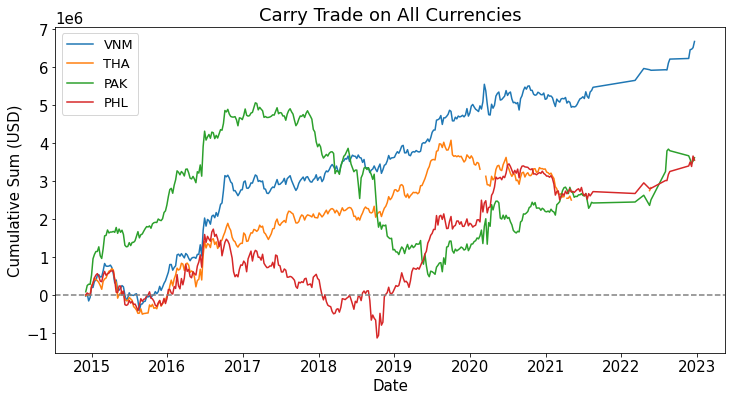

In [497]:
plt.title("Carry Trade on All Currencies")
plt.xlabel('Date')
plt.ylabel('Cumulative Sum (USD)')
plt.plot(all_pnls.cumsum())
plt.legend(['VNM', 'THA', 'PAK', 'PHL'])
plt.axhline(y=0, linestyle='--', color='grey')

Comparing all four currencies, we notice a few correlations, most notably among Vietnamese and Thai currency. Pakistani currency is interesting in that it appears to move fairly independently of the others, as does the Fillipino currency. If we were to construct an actual strategy from this information, it would be worth combining these currencies so that we have positions in all of them which we can adjust over time. The Pakistani currency might act as a hedge for us against the other currencies, and we might even want to short PHL in order to fund more of a position in the others. 

,VNM PNL,THA PNL,PAK PNL,PHL PNL,Total
Date,,,,,
2014-12-03,-28997.632326,-14431.160087,84618.619125,5278.183574,46468.010287
2014-12-10,65868.000352,4029.654651,164739.829281,47902.168931,282539.653215
2014-12-17,-193426.826641,15529.455381,34594.806284,-26457.577013,-169760.141989
2014-12-24,92315.284615,-13258.171074,-2318.086852,-29985.056164,46753.970525
2014-12-31,268410.873118,253361.040106,245202.565000,208259.145816,975233.624040
...,...,...,...,...,...
2022-11-23,16544.179919,NaN,-133615.893286,145467.730529,28396.017162
2022-11-30,230810.727515,NaN,-92578.979475,106451.250161,244682.998201
2022-12-07,11960.365974,NaN,-110096.531995,-119842.828115,-217978.994136


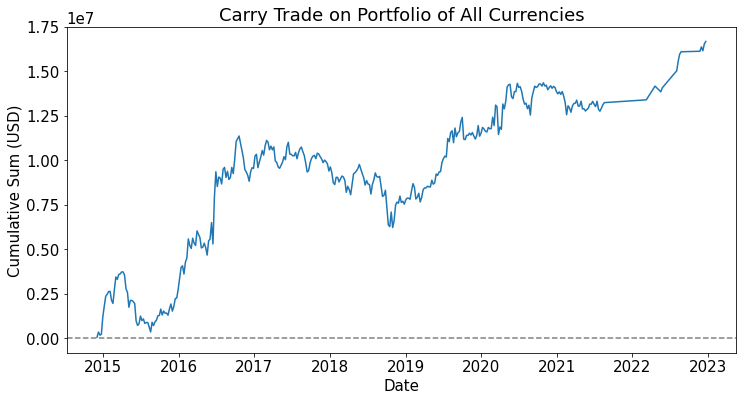

In [498]:
all_pnls['Total'] = all_pnls.sum(axis=1)
display(all_pnls)

plt.title("Carry Trade on Portfolio of All Currencies")
plt.xlabel('Date')
plt.ylabel('Cumulative Sum (USD)')
plt.axhline(y=0, linestyle='--', color='grey')
plt.plot(all_pnls['Total'].cumsum())

As an experiment, I constructed a portfolio with an equal position in all four currencies and looked at the total returns. We don't see any times at which the cumulative pnl goes below zero, but we still see downturns in the profits, notably in 2015 and 2018. Ways to improve this strategy would obviously be to adjust the positions throughout time, as well as take into account other factors like international politics/news. Another potential improvement would be to include currencies from other parts of the world. There are no currencies from Europe represented here, nor any from Central or South America. We might be able to hedge out some of the geographical risk by diversifying this way.

## Analysis

### Correlation

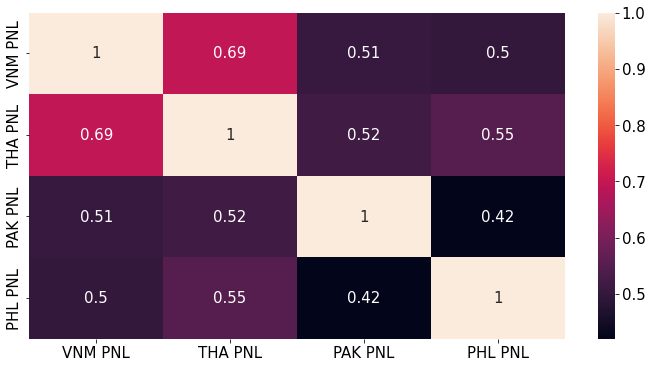

In [499]:
individuals = all_pnls[['VNM PNL', 'THA PNL', 'PAK PNL', 'PHL PNL']]
sns.heatmap(individuals.corr(),annot=True);

The heat map supports what we suspected above, that the returns of these currency carry trades are correlated. THA and VNM most highly with a value of 0.69, while PAK and PHL have the lowest correlation value of 0.42. In an ideal world we would find another currency with a negative correlation so that we could hedge out some risk, but at the very least we have some diversification by including multiple currencies in our portfolio.

### Statistical Analysis 

In [500]:
# display(all_pnls)
returns = all_pnls.copy()
for column in returns.columns.values:
    returns[f'{column[0:3]} Returns'] = returns[column] / 2_000_000
returns = returns[['VNM Returns', 'THA Returns', 'PAK Returns', 'PHL Returns', 'Tot Returns']] 
display(returns)

def tailMetrics(returns, quantile=.05, annualization=52):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Mean (annualized)'] = returns.mean() * annualization
    metrics['Mean (weekly)'] = returns.mean()
    metrics['Vol'] = returns.std() * np.sqrt(annualization)
    metrics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annualization)

    metrics['Min'] = returns.min()
    metrics['Max'] = returns.max()
    metrics['Skewness'] = returns.skew()
    metrics['Kurtosis'] = returns.kurtosis()

    VaR = returns.quantile(quantile)
    CVaR = (returns[returns < returns.quantile(quantile)]).mean()

    metrics[f'VaR ({quantile})'] = VaR
    metrics[f'CVaR ({quantile})'] = CVaR

    return metrics

metrics_df = tailMetrics(returns)
display(metrics_df)

,VNM Returns,THA Returns,PAK Returns,PHL Returns,Tot Returns
Date,,,,,
2014-12-03,-0.014499,-0.007216,0.042309,0.002639,0.023234
2014-12-10,0.032934,0.002015,0.082370,0.023951,0.141270
2014-12-17,-0.096713,0.007765,0.017297,-0.013229,-0.084880
2014-12-24,0.046158,-0.006629,-0.001159,-0.014993,0.023377
2014-12-31,0.134205,0.126681,0.122601,0.104130,0.487617
...,...,...,...,...,...
2022-11-23,0.008272,NaN,-0.066808,0.072734,0.014198
2022-11-30,0.115405,NaN,-0.046289,0.053226,0.122341
2022-12-07,0.005980,NaN,-0.055048,-0.059921,-0.108989


,Mean (annualized),Mean (weekly),Vol,Sharpe,Min,Max,Skewness,Kurtosis,VaR (0.05),CVaR (0.05)
VNM Returns,0.477025,0.009174,0.427873,1.114876,-0.172788,0.338736,0.469393,3.186681,-0.095928,-0.117532
THA Returns,0.218838,0.004208,0.403661,0.542133,-0.203569,0.323630,0.282078,3.587640,-0.083589,-0.117882
PAK Returns,0.258287,0.004967,0.597116,0.432557,-0.335376,0.391795,0.332999,4.440094,-0.126059,-0.188090
PHL Returns,0.253758,0.004880,0.549712,0.461620,-0.257645,0.335336,0.267164,2.159333,-0.119453,-0.160723
Tot Returns,1.191074,0.022905,1.555750,0.765595,-0.779094,1.315154,0.567348,4.096934,-0.317066,-0.433531


After converting the dollar returns to percentages, we can do a better comparison of the four currencies, and the portfolio constructed of all of them (Tot). We can see that the Vietnamese Carry Trade performed the best of the individuals, with the highest mean (annualized) return and one of the lowest volatilities. This leads - unsurprisingly - to a very good Sharpe ratio of over 1. Looking at the tail metrics, we can see that all four of the currencies had a positive skew, which again makes sense due to the construction of the trade. We expect to make money doing this trade by borrowing at a low rate and lending at a high one, with risk being represented by the foreign exchange rates of the currencies.

We can see that this is a fairly significant risk however, by looking at the Value at Risk (VaR). For any given week, there is a five percent chance that any given currency could lose around 10% of capital, and the the overall portfolio could lose as much as 30%! This is inline with the 'Nickels in Front of a Bulldozer' analogy, which states that you can expect to make consistent small returns (like our mean of 1% a week), but that on your worst week you might lose a lot (33% as seen by the Min of PAK Returns).

## Conclusion

Overall this is a good trading strategy, and seems as though it will make money fairly consistently. It also seems like a long term trading strategy that could be executed for a number of years, as long as rebalancing and stop losses were put in place. Expanding on the trading strategy constructed in this analysis, I would like to include more currencies, such as European or South American ones, in order to diversify and potentially find a hedge. I would also like to study the possibility of lending US Dollars and using SOFR, so that we aren't at risk of the GBPUSD exchange rate. I would hopefully see more profitable results by borrowing in our base currency (especially if we suspect that the US Dollar will weaken in the future). An additional variation on this strategy includes borrowing in currencies with lower rates to get even larger positions in the currencies with higher ones. 